# Models

## Content
* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Model evaluation](#Model-evaluation)
* [Inference](#Inference)

## Problem description

In this notebook we will implement a simple neural network model for ground-roll attenuation. It known that raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. It should be suppressed at initial stage of seismograms processing.

## Dataset

Dataset is given by 2 SEGY files with a seismogram before and after ground-roll attenuation according to LIFT procedure. The seismorgam contains 176K traces combined in 51 field records. 

First, we index field records:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

sys.path.append('..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline, B, V, F
from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot, statistics_plot)

%env CUDA_VISIBLE_DEVICES=4

path_raw = '/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))

index.head()

env: CUDA_VISIBLE_DEVICES=4


,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,35,1656,1,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,36,1657,2,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,78,1655,3,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,79,1658,4,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,127,1654,5,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...


Load and visualize sample field record:

In [2]:
batch = (Dataset(index, SeismicBatch).next_batch(3)
         .load(components=('raw', 'lift'), fmt='segy')
         .sort_traces(src=('raw', 'lift'), dst=('raw', 'lift'), sort_by='offset'))

Show raw and filtered traces (sorted by offset):

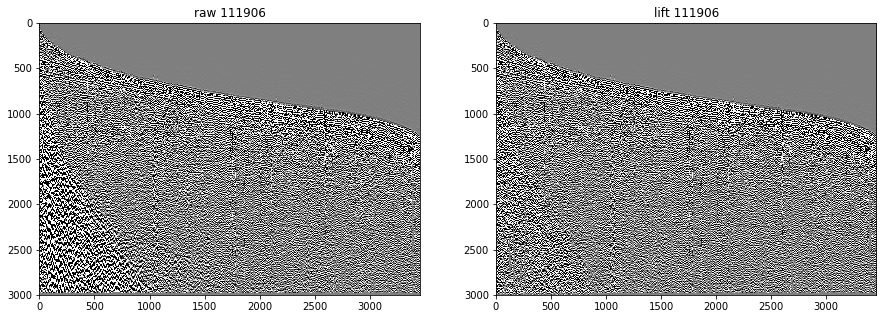

In [3]:
cv = 0.1
batch.seismic_plot(('raw', 'lift'), batch.indices[0], figsize=(15, 5), vmin=-cv, vmax=cv, cmap='gray')

## Model architecture

We exploit a convolutional neural network of the U-net type with depth 5.
Set the model config:

In [4]:
model_config = {
    'initial_block/inputs': 'x',
    'inputs': dict(x={'shape': (3000, 1)}, 
                   y={'name':'targets', 'shape': (3000, 1)}),
    'body/filters': [8, 16, 32, 64, 128],
    'body/encoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
    'body/decoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/upsample': dict(layout='tad', kernel_size=7, strides=2,
                          dropout_rate=0.05, activation=tf.nn.elu),
    'loss': 'l1',
    'optimizer': 'Adam'
}

## Training

Define train dataset:

In [5]:
train_index = index.create_subset(index.indices[:5])
train_set = Dataset(TraceIndex(train_index), SeismicBatch)

Set a training pipeline

In [6]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(np.vstack(batch.raw), -1),
                          'y': np.expand_dims(np.vstack(batch.lift), -1)}}

train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', UNet, 'unet', model_config)
                  .train_model('unet', make_data=make_data,
                               fetches='loss', save_to=V('loss', mode='a'))
                 )

Run the training pipeline:

In [7]:
batch_size = 64

train_pipeline = train_pipeline << train_set
train_pipeline.run(batch_size, n_epochs=3, drop_last=True, shuffle=True, bar=True)

100%|█████████▉| 809/810 [02:16<00:00,  6.02it/s]


Show loss against iterations:

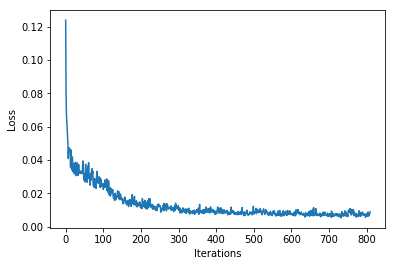

In [8]:
plt.plot(train_pipeline.get_variable("loss"))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

## Model evaluation

Inference pipeline for a quick model estimation:

In [9]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(np.vstack(batch.raw), -1)}}

predict_pipeline = (Pipeline()
                    .import_model('unet', train_pipeline)
                    .init_variable('res', init_on_each_run=list())
                    .init_variable('raw', init_on_each_run=list())
                    .init_variable('lift', init_on_each_run=list())
                    .load(components=('raw', 'lift'), tslice=np.arange(3000),
                          fmt='segy')
                    .update_variable('raw', B('raw'), mode='a')
                    .update_variable('lift', B('lift'), mode='a')
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('res', mode='a'))
                   )

Get a test field record:

In [10]:
test_set = Dataset(TraceIndex(index.create_subset(index.indices[20:21])), SeismicBatch)

Run the inference pipeline on the test subset:

In [11]:
predict_pipeline = predict_pipeline << test_set
predict_pipeline.run(batch_size=1000, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 75%|███████▌  | 3/4 [00:01<00:00,  1.83it/s]


Arrange results:

In [12]:
res = np.squeeze(np.vstack(predict_pipeline.get_variable("res")), axis=-1)
raw = np.vstack(np.concatenate(predict_pipeline.get_variable("raw")))
lift = np.vstack(np.concatenate(predict_pipeline.get_variable("lift")))

Show raw traces, Unet prediction and difference between them:

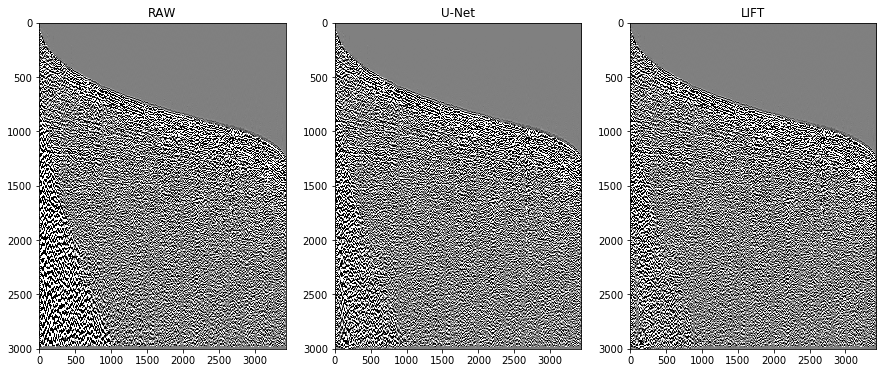

In [13]:
seismic_plot([raw, res, lift], names=['RAW', 'U-Net', 'LIFT'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

Power spectrum comparison:

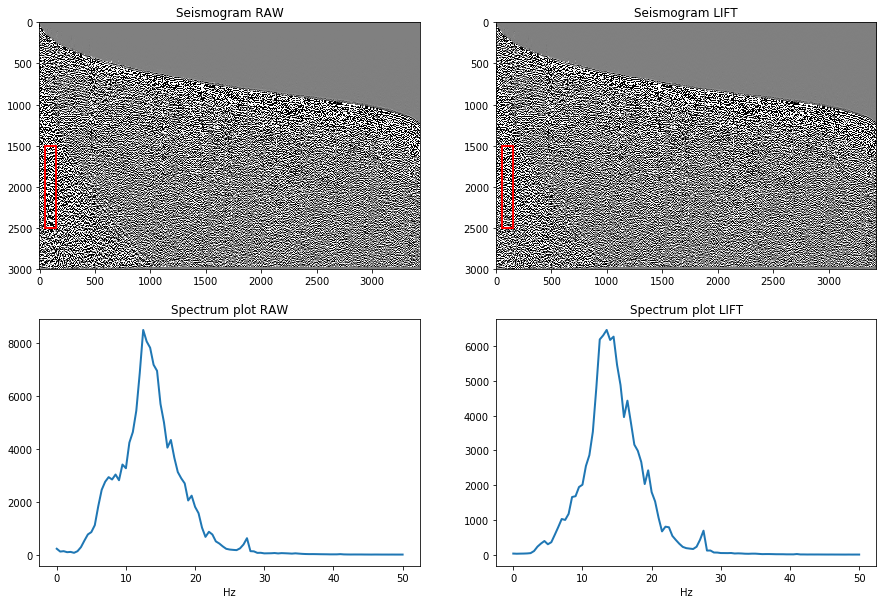

In [14]:
spectrum_plot([res, lift], frame=(slice(50, 150), slice(1500, 2500)), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['RAW', 'LIFT'])

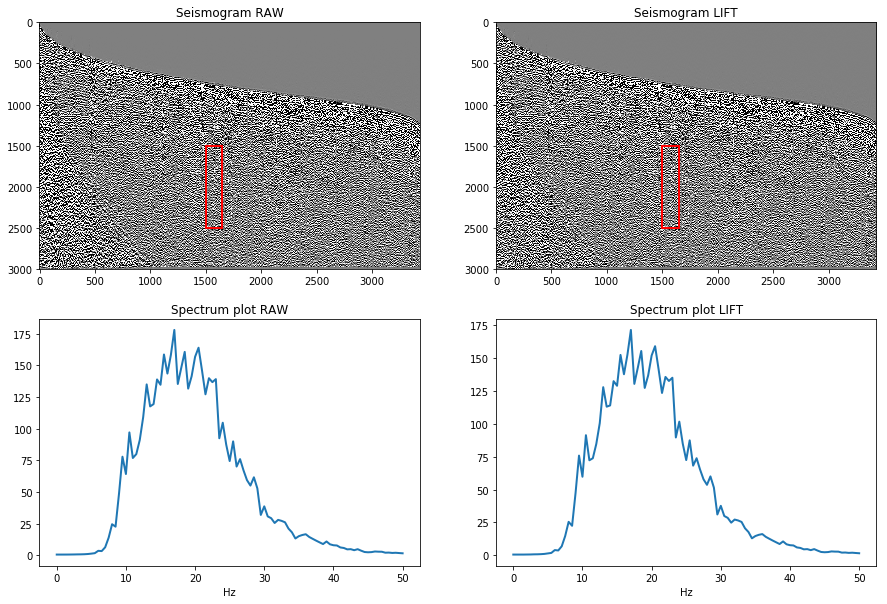

In [15]:
spectrum_plot([res, lift], frame=(slice(1500, 1650), slice(1500, 2500)), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['RAW', 'LIFT'])

Comparison of rms amplitudes:

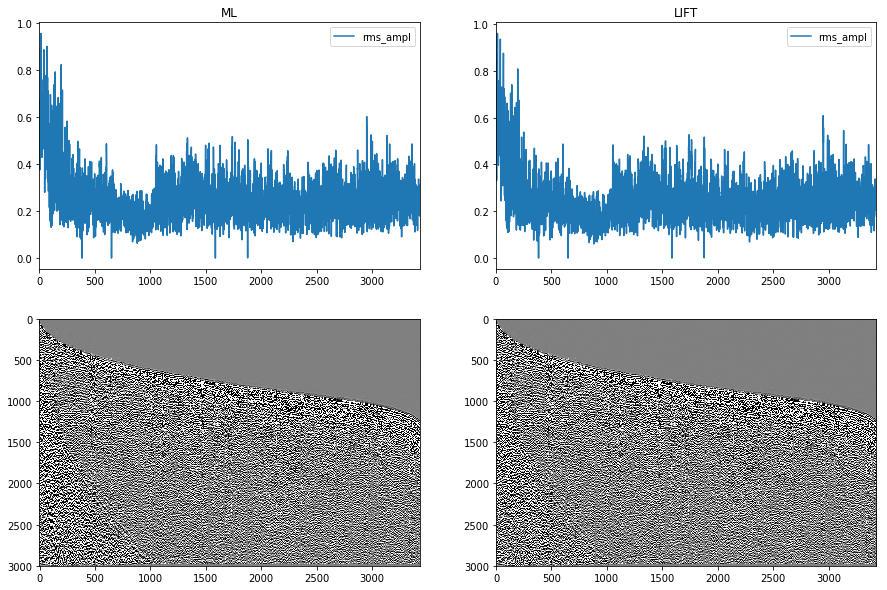

In [16]:
statistics_plot((res, lift), stats='rms_ampl', names=['ML', 'LIFT'], figsize=(15, 10),
                vmin=-cv, vmax=cv, cmap='gray')

Comparison of rms frequencies:

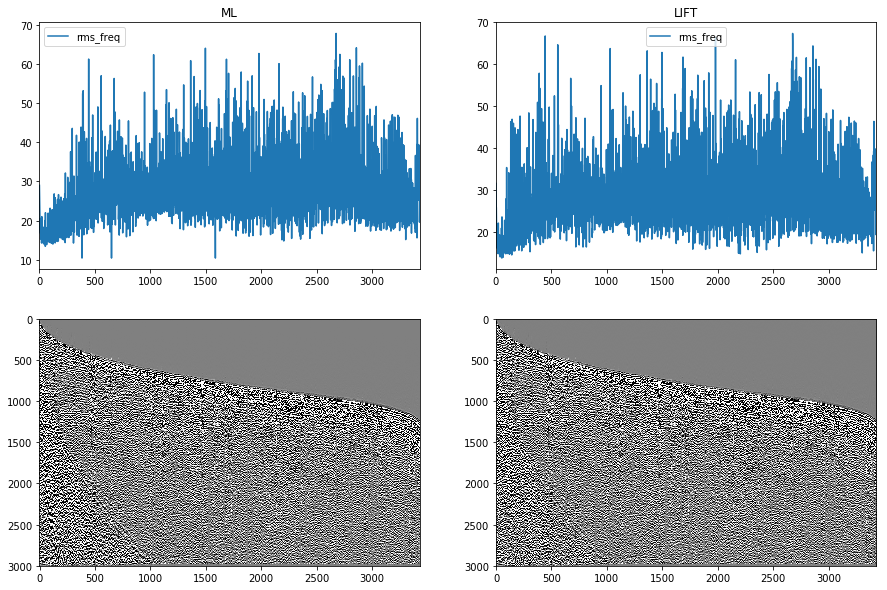

In [17]:
statistics_plot((res, lift), stats='rms_freq', rate=0.002,
                names=['ML', 'LIFT'], figsize=(15, 10),
                vmin=-cv, vmax=cv, cmap='gray')

## Inference

An inference pipeline with dump action:

In [18]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(np.vstack(batch.raw), -1)}}

dump_path = '/notebooks/egor/geolog/notebooks/dumps'

predict_pipeline = (Pipeline()
                    .load(components='raw', fmt='segy', tslice=np.arange(3000))
                    .import_model('unet', train_pipeline)
                    .init_variable('count', init_on_each_run=0)
                    .predict_model('unet', fetches='predictions', 
                                   make_data=make_data, save_to=B('raw'))
                    .dump(fmt='segy', path=F(lambda _, x: os.path.join(dump_path, str(x) + '.sgy'), V('count')),
                          src='raw', split=False)
                    .update_variable('count', F(lambda _, x: x + 1, V('count')))
                   )

Run inference on the whole dataset:

In [19]:
batch_size = 1000
predict_pipeline = predict_pipeline << Dataset(TraceIndex(index), SeismicBatch)
predict_pipeline.run(batch_size, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 99%|█████████▉| 175/176 [01:59<00:00,  1.47it/s]


Finally, merge the output files into a single segy file:

In [21]:
merge_segy_files(path=os.path.join(dump_path, '*sgy'),
                 output_path='/notebooks/egor/geolog/notebooks/merged.sgy')

Done!